In [0]:
import cvxopt
import csv
import pandas as pd
import numpy as np
from random import randint
import time
from tqdm import tqdm, tqdm_notebook
import math
import pickle
from cvxopt import solvers
from cvxopt import matrix
from scipy.spatial.distance import pdist, cdist
from sklearn.svm import SVC
from tqdm import trange
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import math
from joblib import Parallel,delayed

In [0]:
train= pd.read_csv('fashion_mnist/train.csv',header=None).to_numpy()
val= pd.read_csv('fashion_mnist/val.csv',header=None).to_numpy()
test= pd.read_csv('fashion_mnist/test.csv',header=None).to_numpy()

In [0]:
def load_train_data(a,b):
    train_data = np.array([train[i,:] for i in range(train.shape[0]) if train[i,-1]== a or train[i,-1]==b ] )  
    X = train_data[:, :-1]/255
    m= X.shape[0]
    Y1 = train_data[:,-1].reshape((m,1))
    Y1[Y1==a] = -1
    Y1[Y1==b] = 1
    return X,Y1

In [0]:
def load_data():
  X = train[:, :-1]/255
  m= X.shape[0]
  Y1 = train[:,-1].reshape((m,1))

  X_val = val[:, :-1]/255
  m_val= X_val.shape[0]
  Y1_val = val[:,-1].reshape((m_val,1))

  X_test = test[:, :-1]/255
  m_test= X_test.shape[0]
  Y1_test = test[:,-1].reshape((m_test,1))

  return X_val, Y1_val, X_test, Y1_test, X,Y1

In [0]:
def find_accuracy(y, y_pred):
    correct =0  
    for i in range(len(y)): 
        if y[i] == y_pred[i]:
            correct +=1
    return (correct/len(y)) *100, 

In [0]:
def svm_gaussian(X,Y):
    m= X.shape[0]
    t =cdist(X,X,'euclidean')
    K = np.exp((t**2) * (-0.05))
    YY = Y@Y.T
    P=matrix(np.multiply(K,YY))
    q=matrix(np.ones([m,1])*-1)
    I = np.identity(m)
    I_neg = np.identity(m)*-1
    G = matrix(np.concatenate([I,I_neg]))
    A=matrix(Y.reshape((1,m)))
    b = matrix([0], tc='d')
    Y=Y.reshape(m)
    h = matrix(np.concatenate((np.ones([m,1]),np.zeros([m,1]))))    
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    alpha=np.array(sol['x'])   
    SV_i =[i for i in range(len(alpha)) if alpha[i] >=1e-6]
    alpha1= np.array([alpha[i] for i in SV_i])
    SV_X = np.array([X[i] for i in SV_i])
    SV_Y = np.array([Y[i] for i in SV_i]).reshape((SV_X.shape[0],1))   
    X_pos= np.array([X[i] for i in range(len(Y)) if Y[i]==1.0])
    X_neg= np.array([X[i] for i in range(len(Y)) if Y[i]==-1.0])
    print(X_neg.shape)
    t_neg= cdist(SV_X,X_neg,'euclidean')
    K_neg= np.exp((t_neg**2) * (-0.05))
    t_pos= cdist(SV_X,X_pos,'euclidean')
    K_pos= np.exp((t_pos**2) * (-0.05))
    X_neg_k =np.dot(K_neg.T,(SV_Y*alpha1))
    X_pos_k =np.dot(K_pos.T,(SV_Y*alpha1))
    b = -(X_neg_k.max()+X_pos_k.min())/2
    print(alpha1.shape,SV_X.shape,X_pos.shape, X_neg.shape,  X_neg_k.shape)
    return [alpha1,b,SV_X, SV_Y]

In [0]:
def find_max_class(dict):
  max =0
  max_key=-1
  for key in dict:
    if(dict[key][0]>max):
      max = dict[key][0]
      max_key=key
    elif (dict[key][0]==max):
      if(dict[key][1]>dict[max_key][1]):
        max_key = key
  return max_key

In [0]:
def predict_gaussian(X):
  count=0;
  class_pred=[]
  for i in range(X.shape[0]):
    dict={}
    for i in range(10):
      dict[i]= [0,0] 
    class_pred.append(dict)
  for i in range(45):
    [alpha,b,SV_X, SV_Y,p,q]=models[i]
    t= cdist(SV_X,X,'euclidean')
    K= np.exp((t**2) * (-0.05))
    pred = np.dot(K.T,(SV_Y*alpha))+b
    pred= pred.tolist()
    Y_pred =[]
    for j in range(len(pred)) :
      if pred[j][0] >0:         
          class_pred[j][q][0]+=1
          class_pred[j][q][1]+=pred[j][0]
      else :
          class_pred[j][p][0]+=1
          class_pred[j][p][1]+=abs(pred[j][0])
  for i in range(X.shape[0]):
    Y_pred.append(find_max_class(class_pred[i])) 
  return Y_pred

In [11]:
l_model=[]
classes= list(range(10))
for i in trange(10):
    for j in trange(i+1, 10):
        X,Y=load_train_data(classes[i],classes[j])
        print(classes[i],classes[j])
        model= svm_gaussian(X,Y)
        l_model.append(model)

  0%|          | 0/9 [00:00<?, ?it/s]

0 1
(2250, 784)



 11%|█         | 1/9 [00:36<04:55, 36.90s/it]

(858, 1) (858, 784) (2250, 784) (2250, 784) (2250, 1)
0 2
(2250, 784)



 22%|██▏       | 2/9 [01:13<04:17, 36.84s/it]

(1334, 1) (1334, 784) (2250, 784) (2250, 784) (2250, 1)
0 3
(2250, 784)



 33%|███▎      | 3/9 [01:50<03:40, 36.81s/it]

(1566, 1) (1566, 784) (2250, 784) (2250, 784) (2250, 1)
0 4
(2250, 784)



 44%|████▍     | 4/9 [02:26<03:02, 36.53s/it]

(1103, 1) (1103, 784) (2250, 784) (2250, 784) (2250, 1)
0 5
(2250, 784)



 56%|█████▌    | 5/9 [03:02<02:25, 36.43s/it]

(1034, 1) (1034, 784) (2250, 784) (2250, 784) (2250, 1)
0 6
(2250, 784)



 67%|██████▋   | 6/9 [03:42<01:52, 37.42s/it]

(2574, 1) (2574, 784) (2250, 784) (2250, 784) (2250, 1)
0 7
(2250, 784)



 78%|███████▊  | 7/9 [04:19<01:14, 37.25s/it]

(612, 1) (612, 784) (2250, 784) (2250, 784) (2250, 1)
0 8
(2250, 784)



 89%|████████▉ | 8/9 [04:55<00:37, 37.13s/it]

(1342, 1) (1342, 784) (2250, 784) (2250, 784) (2250, 1)
0 9
(2250, 784)



  0%|          | 0/8 [00:00<?, ?it/s]

(878, 1) (878, 784) (2250, 784) (2250, 784) (2250, 1)
1 2
(2250, 784)



 12%|█▎        | 1/8 [00:37<04:19, 37.07s/it]

(844, 1) (844, 784) (2250, 784) (2250, 784) (2250, 1)
1 3
(2250, 784)



 25%|██▌       | 2/8 [01:16<03:46, 37.78s/it]

(995, 1) (995, 784) (2250, 784) (2250, 784) (2250, 1)
1 4
(2250, 784)



 38%|███▊      | 3/8 [01:53<03:07, 37.46s/it]

(762, 1) (762, 784) (2250, 784) (2250, 784) (2250, 1)
1 5
(2250, 784)



 50%|█████     | 4/8 [02:31<02:31, 37.84s/it]

(806, 1) (806, 784) (2250, 784) (2250, 784) (2250, 1)
1 6
(2250, 784)



 62%|██████▎   | 5/8 [03:09<01:53, 37.79s/it]

(970, 1) (970, 784) (2250, 784) (2250, 784) (2250, 1)
1 7
(2250, 784)



 75%|███████▌  | 6/8 [03:47<01:15, 37.79s/it]

(404, 1) (404, 784) (2250, 784) (2250, 784) (2250, 1)
1 8
(2250, 784)



 88%|████████▊ | 7/8 [04:26<00:38, 38.16s/it]

(985, 1) (985, 784) (2250, 784) (2250, 784) (2250, 1)
1 9
(2250, 784)



  0%|          | 0/7 [00:00<?, ?it/s]

(636, 1) (636, 784) (2250, 784) (2250, 784) (2250, 1)
2 3
(2250, 784)



 14%|█▍        | 1/7 [00:36<03:41, 36.89s/it]

(1145, 1) (1145, 784) (2250, 784) (2250, 784) (2250, 1)
2 4
(2250, 784)



 29%|██▊       | 2/7 [01:16<03:08, 37.75s/it]

(2462, 1) (2462, 784) (2250, 784) (2250, 784) (2250, 1)
2 5
(2250, 784)



 43%|████▎     | 3/7 [01:53<02:29, 37.36s/it]

(1120, 1) (1120, 784) (2250, 784) (2250, 784) (2250, 1)
2 6
(2250, 784)



 57%|█████▋    | 4/7 [02:33<01:54, 38.25s/it]

(2597, 1) (2597, 784) (2250, 784) (2250, 784) (2250, 1)
2 7
(2250, 784)



 71%|███████▏  | 5/7 [03:11<01:16, 38.34s/it]

(634, 1) (634, 784) (2250, 784) (2250, 784) (2250, 1)
2 8
(2250, 784)



 86%|████████▌ | 6/7 [03:50<00:38, 38.54s/it]

(1433, 1) (1433, 784) (2250, 784) (2250, 784) (2250, 1)
2 9
(2250, 784)



  0%|          | 0/6 [00:00<?, ?it/s]

(891, 1) (891, 784) (2250, 784) (2250, 784) (2250, 1)
3 4
(2250, 784)



 17%|█▋        | 1/6 [00:38<03:12, 38.54s/it]

(1280, 1) (1280, 784) (2250, 784) (2250, 784) (2250, 1)
3 5
(2250, 784)



 33%|███▎      | 2/6 [01:17<02:34, 38.57s/it]

(929, 1) (929, 784) (2250, 784) (2250, 784) (2250, 1)
3 6
(2250, 784)



 50%|█████     | 3/6 [01:56<01:56, 38.93s/it]

(1658, 1) (1658, 784) (2250, 784) (2250, 784) (2250, 1)
3 7
(2250, 784)



 67%|██████▋   | 4/6 [02:33<01:16, 38.20s/it]

(550, 1) (550, 784) (2250, 784) (2250, 784) (2250, 1)
3 8
(2250, 784)



 83%|████████▎ | 5/6 [03:10<00:37, 37.73s/it]

(1304, 1) (1304, 784) (2250, 784) (2250, 784) (2250, 1)
3 9
(2250, 784)



  0%|          | 0/5 [00:00<?, ?it/s]

(769, 1) (769, 784) (2250, 784) (2250, 784) (2250, 1)
4 5
(2250, 784)



 20%|██        | 1/5 [00:37<02:31, 37.83s/it]

(1028, 1) (1028, 784) (2250, 784) (2250, 784) (2250, 1)
4 6
(2250, 784)



 40%|████      | 2/5 [01:17<01:54, 38.29s/it]

(2439, 1) (2439, 784) (2250, 784) (2250, 784) (2250, 1)
4 7
(2250, 784)



 60%|██████    | 3/5 [01:53<01:15, 37.67s/it]

(584, 1) (584, 784) (2250, 784) (2250, 784) (2250, 1)
4 8
(2250, 784)



 80%|████████  | 4/5 [02:30<00:37, 37.59s/it]

(1348, 1) (1348, 784) (2250, 784) (2250, 784) (2250, 1)
4 9
(2250, 784)



  0%|          | 0/4 [00:00<?, ?it/s]

(843, 1) (843, 784) (2250, 784) (2250, 784) (2250, 1)
5 6
(2250, 784)



 25%|██▌       | 1/4 [00:39<01:59, 39.90s/it]

(1140, 1) (1140, 784) (2250, 784) (2250, 784) (2250, 1)
5 7
(2250, 784)



 50%|█████     | 2/4 [01:18<01:18, 39.44s/it]

(1505, 1) (1505, 784) (2250, 784) (2250, 784) (2250, 1)
5 8
(2250, 784)



 75%|███████▌  | 3/4 [01:56<00:39, 39.22s/it]

(1636, 1) (1636, 784) (2250, 784) (2250, 784) (2250, 1)
5 9
(2250, 784)



  0%|          | 0/3 [00:00<?, ?it/s]

(1342, 1) (1342, 784) (2250, 784) (2250, 784) (2250, 1)
6 7
(2250, 784)



 33%|███▎      | 1/3 [00:37<01:15, 37.51s/it]

(684, 1) (684, 784) (2250, 784) (2250, 784) (2250, 1)
6 8
(2250, 784)



 67%|██████▋   | 2/3 [01:16<00:37, 37.86s/it]

(1570, 1) (1570, 784) (2250, 784) (2250, 784) (2250, 1)
6 9
(2250, 784)



  0%|          | 0/2 [00:00<?, ?it/s]

(940, 1) (940, 784) (2250, 784) (2250, 784) (2250, 1)
7 8
(2250, 784)



 50%|█████     | 1/2 [00:38<00:38, 38.43s/it]

(1089, 1) (1089, 784) (2250, 784) (2250, 784) (2250, 1)
7 9
(2250, 784)



  0%|          | 0/1 [00:00<?, ?it/s]

(1287, 1) (1287, 784) (2250, 784) (2250, 784) (2250, 1)
8 9
(2250, 784)



 90%|█████████ | 9/10 [28:23<02:01, 121.31s/it]
0it [00:00, ?it/s]
100%|██████████| 10/10 [28:23<00:00, 170.31s/it]

(1270, 1) (1270, 784) (2250, 784) (2250, 784) (2250, 1)


In [0]:
def print_confusion_martix(Y_actual, Y_pred):
  m = np.zeros((10, 10)).astype(int)
  for i in range(Y_actual.shape[0]):
    m[Y_actual[i]][Y_pred[i]]+=1  
  return m

In [0]:
models_pickle = open("models_pickle",'wb')
pickle.dump(l_model, models_pickle)

In [0]:
file= open("models_pickle",'rb')
models = pickle.load(file)
file.close()
count =0
for i in range(10):
    for j in range(i+1, 10):
        models[count].append(i)
        models[count].append(j)
        count+=1
models = np.array(models)

In [15]:
X_val, Y_val, X_test, Y_test, X_train, Y_train=load_data()
s = time.time()
pred_val=predict_gaussian(X_val)
print('prediction time in validation set ', time.time()-s)

prediction time in validation set  87.89004588127136


### Accuracy on validation -  84.96
 

In [16]:
accuracy = find_accuracy(Y_val, pred_val)
print('Accuracy on validation set  -', accuracy)

Accuracy on validation set  - (84.96000000000001,)


In [17]:
s = time.time()
pred_test=predict_gaussian(X_test)
print('prediction time in test set ', time.time()-s)

prediction time in test set  216.46912360191345


### Accuracy on test data- 85.08

In [18]:
acc=find_accuracy(Y_test, pred_test)
print('Accuracy on test data -', acc )

Accuracy on test data - (85.08,)


In [0]:
# s= time.time()
# pred_train=predict_gaussian(X_train)
# print('prediction time in train set ', time.time()-s)

# Accuracy on train data = 96.52

In [0]:
# accuracy =find_accuracy(Y_train, pred_train)
# print('accuracy on train data - ', accuracy)

# 2(b) Using  Scikit learn

In [0]:
def train_multiclass_svm_sklearn(classes):
  skl_model=[]
  for i in trange(10):
      for j in range(i+1, 10):
          train_data = np.array([train[k,:] for k in range(train.shape[0]) if train[k,-1]== i or train[k,-1]==j ] )  
          X = train_data[:, :-1]/255
          m= X.shape[0]
          Y = train_data[:,-1].reshape((m,1))
          print(classes[i],classes[j])
          svc = SVC(kernel='rbf', gamma=0.05, C=1, decision_function_shape='ovo')
          svc.fit(X, np.ravel(Y ,order = 'C'))
          skl_model.append(svc)
  return skl_model

In [22]:
classes= list(range(10))
s = time.time()
skl_model = train_multiclass_svm_sklearn(classes)
models_pickle_svc = open("models_pickle_svc",'wb')
pickle.dump(skl_model, models_pickle_svc)
print(time.time()-s)

  0%|          | 0/10 [00:00<?, ?it/s]

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


 10%|█         | 1/10 [01:07<10:10, 67.82s/it]

1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9


 20%|██        | 2/10 [01:46<07:53, 59.17s/it]

2 3
2 4
2 5
2 6
2 7
2 8
2 9


 30%|███       | 3/10 [02:48<06:59, 59.89s/it]

3 4
3 5
3 6
3 7
3 8
3 9


 40%|████      | 4/10 [03:27<05:21, 53.56s/it]

4 5
4 6
4 7
4 8
4 9


 50%|█████     | 5/10 [04:06<04:06, 49.30s/it]

5 6
5 7
5 8
5 9


 60%|██████    | 6/10 [04:41<03:00, 45.03s/it]

6 7
6 8
6 9


 70%|███████   | 7/10 [05:02<01:53, 37.81s/it]

7 8
7 9


 80%|████████  | 8/10 [05:17<01:01, 30.96s/it]

8 9


100%|██████████| 10/10 [05:25<00:00, 32.51s/it]


330.1524829864502


In [0]:
file1= open("models_pickle_svc",'rb')
models_svc = pickle.load(file1)

In [0]:
file= open("models_pickle_svc",'rb')
models = pickle.load(file)
file.close()
classes=[]
count =0
for i in range(10):
    for j in range(i+1, 10):
        classes.append((i,j))
models = np.array(models)

In [0]:
def predict_gaussian_svm(X):
  count=0;
  class_pred=[]
  Y_pred_class=[]
  for i in range(X.shape[0]):
    dict={}
    for j in range(10):
      dict[j]= [0,0] 
    class_pred.append(dict)
  for i in range(45):
      (p,q)=classes[i]
      modeli=models[i]
      Y_pred = modeli.predict(X)
      Y_scores= modeli.decision_function(X)
      for j in range(len(Y_pred)) :        
            class_pred[j][Y_pred[j]][0]+=1
            class_pred[j][Y_pred[j]][1]+=abs(Y_scores[j])
  for i in range(X.shape[0]):
    Y_pred_class.append(find_max_class(class_pred[i])) 
  return Y_pred_class

In [26]:
pred_val_sk=predict_gaussian_svm(X_val)
accuracy = find_accuracy(Y_val, pred_val_sk)
print('Accuracy on validation set using sklearn binary classifier', accuracy)

Accuracy on validation set using sklearn binary classifier (87.88,)


### accuracy on test set - 88.08

In [28]:
pred_test_sk = predict_gaussian_svm(X_test)
accuracy = find_accuracy(Y_test, pred_test_sk)
print('Accuracy on training set using sklearn binary classifier', accuracy)

Accuracy on training set using sklearn binary classifier (88.08,)


### accuracy on train test using sklearn -96.92888888888889

## 2(c) Confusion Matrix

Confusion matrix on train set


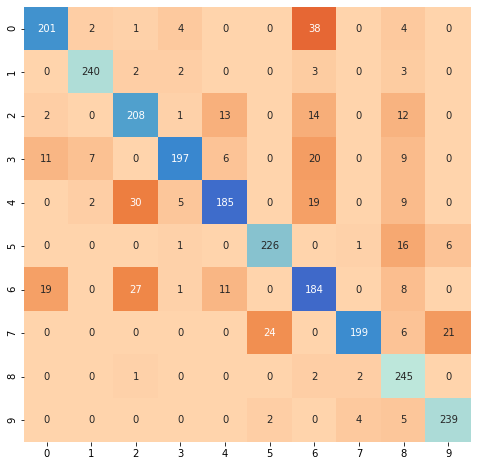

In [30]:
print('Confusion matrix on validation set')
a= print_confusion_martix(Y_val.astype(int).ravel(), np.array(pred_val).astype(int))
classes= list(range(10))
x,b=plt.subplots(figsize=(8,8))
plt.ylabel('Actual')
plt.xlabel('Predicted')
t=sns.heatmap(a,annot=True, fmt="d",cbar=False,cmap="icefire_r")
plt.show()

Confusion matrix on test set


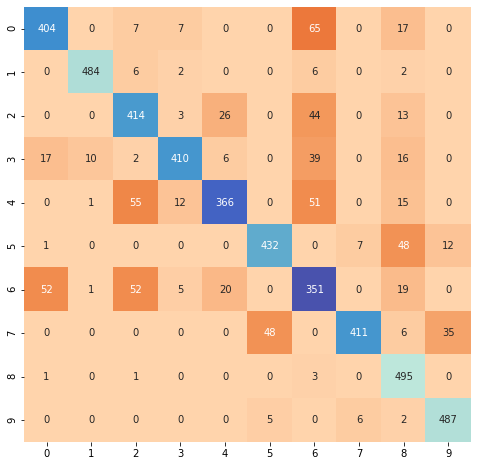

In [31]:
print('Confusion matrix on test set using scikit learn ')
a=print_confusion_martix(Y_test.astype(int).ravel(), np.array(pred_test).astype(int))
plt.figure(figsize=(8,8))
t=sns.heatmap(a,annot=True, fmt="d",cbar=False,cmap="icefire_r")

Confusion matrix on valiadtion set


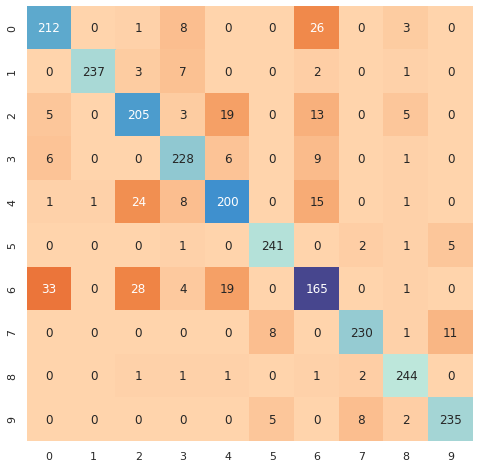

In [32]:
print('Confusion matrix on valiadtion set')
a= print_confusion_martix(Y_val.astype(int).ravel(), np.array(pred_val_sk).astype(int))
sns.set()
plt.figure(figsize=(8,8))
t=sns.heatmap(a,annot=True, fmt="d",cbar=False,cmap="icefire_r")

Confusion matrix on test set using Scikit Learn


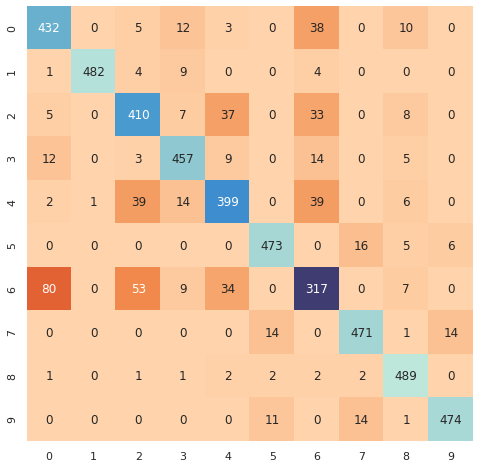

In [33]:
print('Confusion matrix on test set using Scikit Learn')
a=print_confusion_martix(Y_test.astype(int).ravel(), np.array(pred_test_sk).astype(int))
plt.figure(figsize=(8,8))
t=sns.heatmap(a,annot=True, fmt="d",cbar=False,cmap="icefire_r")

In [34]:
X = train[:,:-1]/255 
Y = train[:, -1]
print(X.shape, Y.shape)
k=5
models=[]
C_values = [1e-5,1e-3,1, 5 ,10]
skf = StratifiedKFold(n_splits=k)
skf.get_n_splits(X, Y)

(22500, 784) (22500,)


5

In [0]:
def train_svc_multiclass(i):
    count=0
    avg_acc=0
    for train_index, test_index in skf.split(X, Y):
        count+=1
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]  
        svc = SVC(kernel='rbf', gamma=0.05, C=i, decision_function_shape='ovo')
        svc.fit(X_train, Y_train.ravel())
        print('done')
        models.append([svc,i,count])
        score= svc.score(X_test, Y_test)
        avg_acc = avg_acc+ score
        print(score, i,count)
    return avg_acc/k

In [38]:
s = time.time()
accuracy_on_c=Parallel(n_jobs=8)(delayed(train_svc_multiclass)(i) for i in C_values )
print(time.time()-s)

5416.033528089523


In [39]:
print(accuracy_on_c)
k_fold_acc = open('k_fold_acc','wb')
pickle.dump(accuracy_on_c, k_fold_acc)

[0.5664444444444444, 0.5664444444444444, 0.8787111111111111, 0.8844, 0.8842666666666666]


In [0]:
test_accuracy=[]
C_values = [1e-5,1e-3,1, 5 ,10]
for i in C_values:
    svc = SVC(kernel='rbf', gamma=0.05, C=i, decision_function_shape='ovo')
    svc.fit(X, Y.ravel())
    test_accuracy.append(svc.score(X_test, Y_test))

In [45]:
test_accuracy

[0.5736, 0.5736, 0.8808, 0.8828, 0.8824]

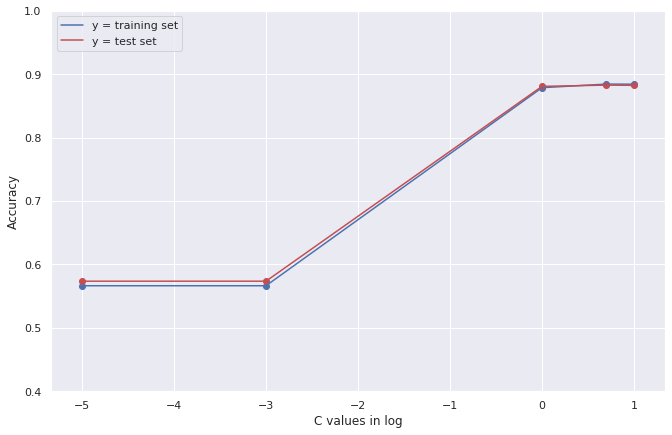

In [67]:
train_acc=[0.5664444444444444, 0.5664444444444444, 0.8787111111111111, 0.8844, 0.8842666666666666]
test_acc = [0.5736, 0.5736, 0.8808, 0.8828, 0.8824]
train_accuracy = accuracy_on_c
plt.figure(figsize=(11,7))
plt.plot(np.log10(C_values), train_accuracy, color='b')
plt.plot(np.log10(C_values), test_accuracy, color='r')
plt.scatter(np.log10(C_values), train_accuracy, color='b')
plt.scatter(np.log10(C_values), test_accuracy, color='r')
plt.legend(['y = training set', 'y = test set', ], loc='upper left')
plt.xlabel('C values in log')
plt.ylabel('Accuracy')
plt.ylim((0.4,1))
plt.show()

Text(0, 0.5, 'Accuracy')

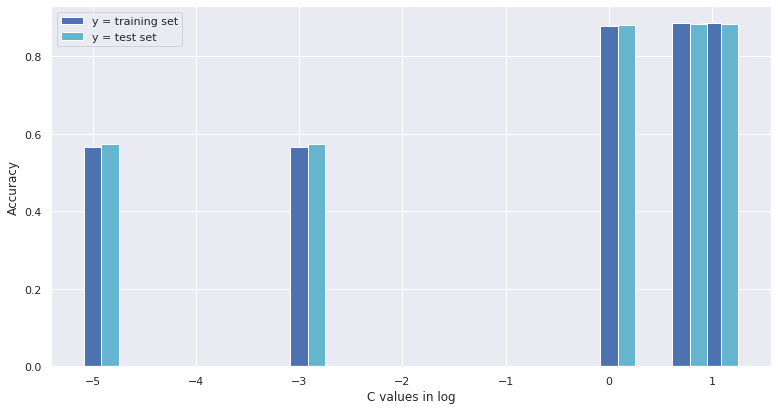

In [69]:
fig = plt.figure(figsize=(10,5))
C_values = [1e-5,1e-3,1, 5 ,10]
ax = fig.add_axes([0,0,1,1])
ax.bar(np.log10(C_values) + 0.00, train_accuracy, color = 'b', width = 0.17)
ax.bar(np.log10(C_values) + 0.17, test_accuracy, color = 'c', width = 0.17)
ax.legend(['y = training set', 'y = test set', ], loc='upper left')
plt.xlabel('C values in log')
plt.ylabel('Accuracy')